In [4]:
! pip install kaggle

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download alessiocorrado99/animals10
! unzip animals10.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import PIL
import os
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [2]:
translate = {
    "cane": "dog",
    "gatto": "cat",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel",
}
# Define the path to the dataset
dataset_path = './raw-img/'

height, width = 93, 93
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []

In [3]:
# Split each category into train and test sets
for img_class, class_english in translate.items():
    class_path = os.path.join(dataset_path, img_class)
    class_images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    print(class_english, '>>', len(class_images))

    # First split into train and remaining (validation + test)
    train_imgs, remaining_imgs = train_test_split(class_images, train_size=0.7, random_state=42)
    # Further split remaining into validation and test
    val_imgs, test_imgs = train_test_split(remaining_imgs, train_size=0.5, random_state=42)

    for img_path in train_imgs:
        img = tf.keras.preprocessing.image.load_img(img_path, grayscale=False, color_mode="rgb", target_size=(height, width))
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        train_images.append(img)
        train_labels.append(class_english)

    for img_path in val_imgs:
        img = tf.keras.preprocessing.image.load_img(img_path, grayscale=False, color_mode="rgb", target_size=(height, width))
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        val_images.append(img)
        val_labels.append(class_english)

    for img_path in test_imgs:
        img = tf.keras.preprocessing.image.load_img(img_path, grayscale=False, color_mode="rgb", target_size=(height, width))
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        test_images.append(img)
        test_labels.append(class_english)

dog >> 4863
cat >> 1668
horse >> 2623
elephant >> 1446
butterfly >> 2112
chicken >> 3098
cow >> 1866
sheep >> 1820
spider >> 4821
squirrel >> 1862


In [4]:
# Convert to numpy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)
val_images = np.array(val_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

# Encode labels
label_to_index = {name: index for index, name in enumerate(np.unique(train_labels))}
index_to_label = {index: name for name, index in label_to_index.items()}
train_labels = np.array([label_to_index[label] for label in train_labels])
test_labels = np.array([label_to_index[label] for label in test_labels])
val_labels = np.array([label_to_index[label] for label in val_labels])

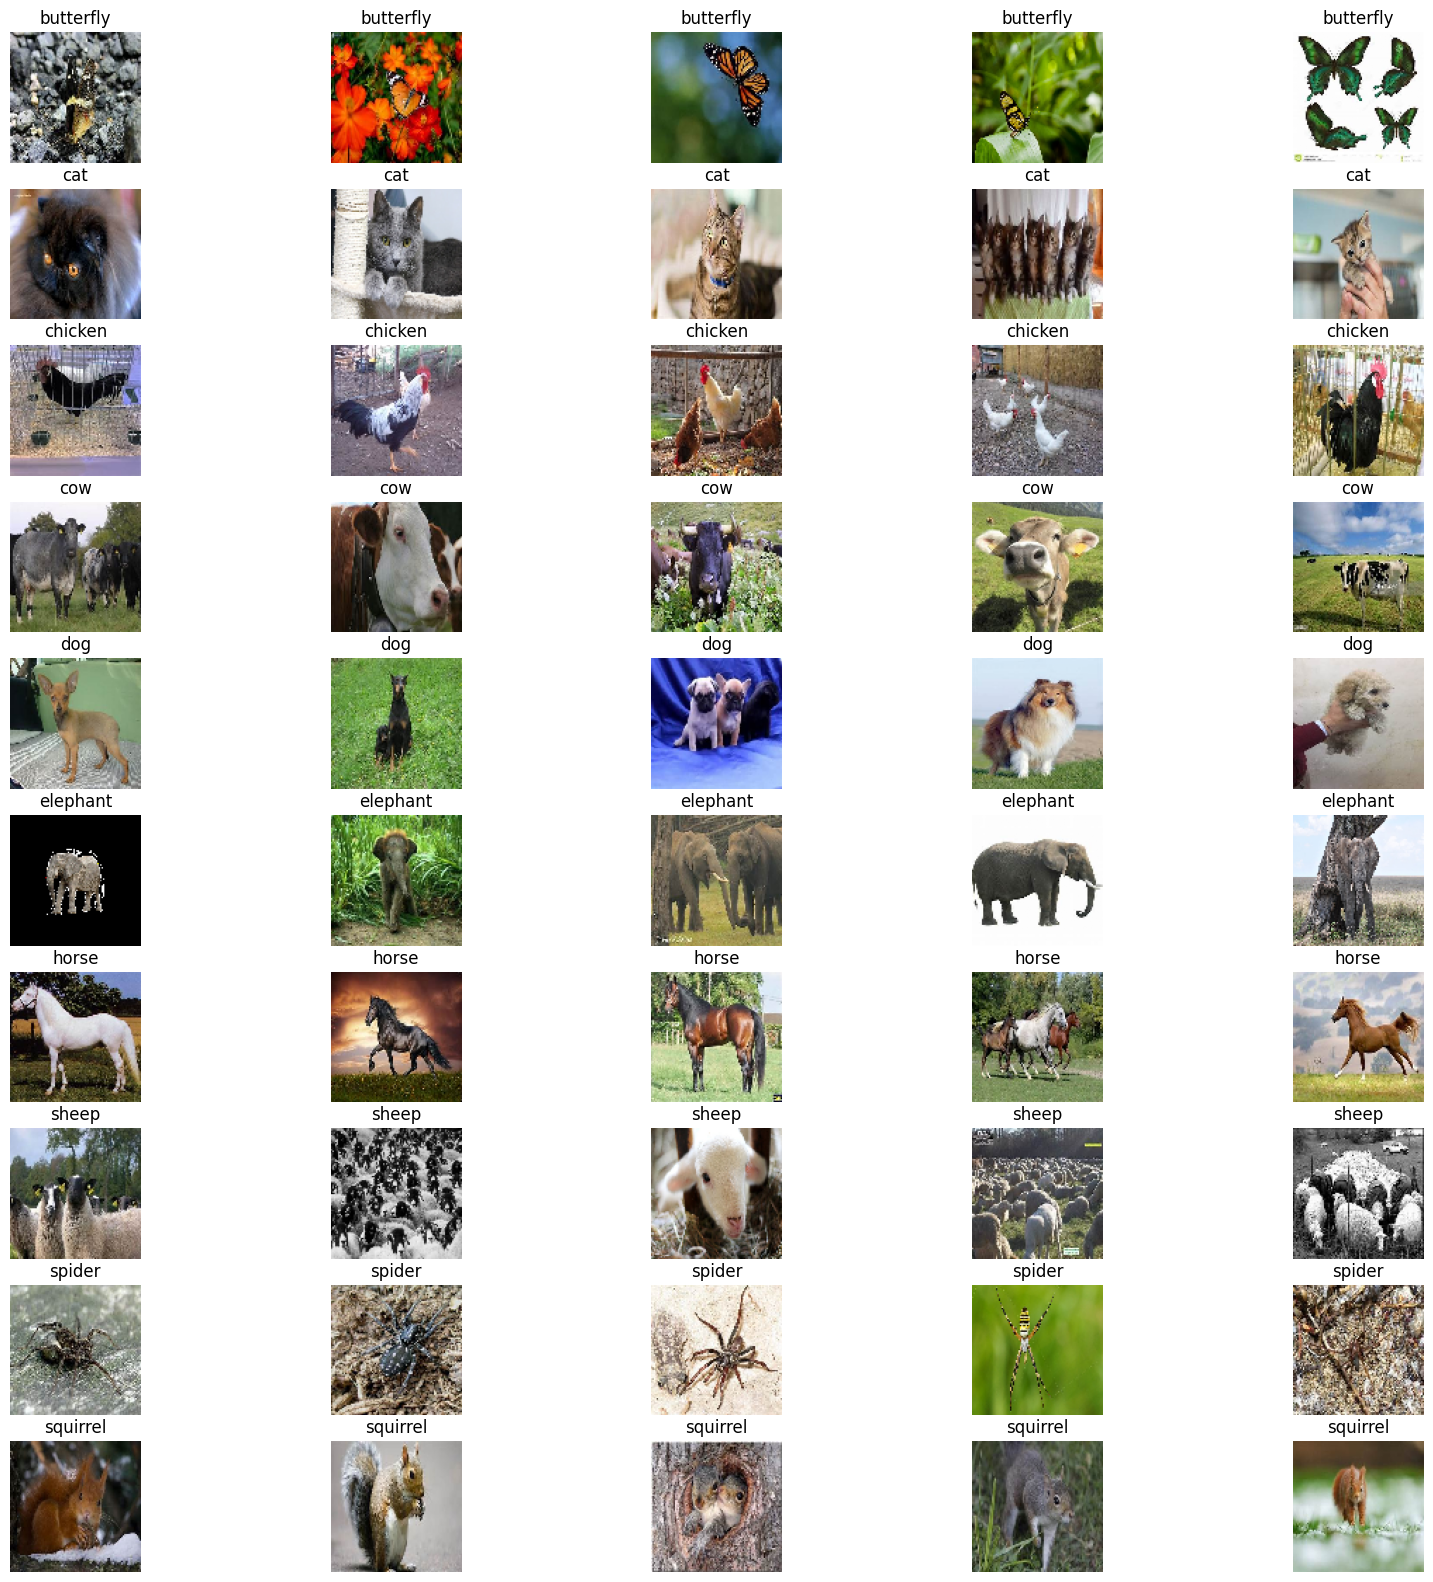

In [5]:
# Display function
def display_images(images, labels, classes, num_images=5):
    plt.figure(figsize=(20, 20))
    for idx, cls in enumerate(classes):
        class_indices = np.where(labels == cls)[0]
        selected_indices = np.random.choice(class_indices, num_images, replace=False)
        for i, img_idx in enumerate(selected_indices):
            plt.subplot(len(classes), num_images, idx * num_images + i + 1)
            plt.imshow(images[img_idx])
            plt.title(index_to_label[cls])
            plt.axis('off')
    plt.show()

# Example usage of display_images function
display_images(train_images, train_labels, np.unique(train_labels))

In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

def create_inception_model(input_shape, num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Create the model
input_shape = (height, width, 3)  # Adjust if necessary
num_classes = len(label_to_index)
inception_model = create_inception_model(input_shape, num_classes)

# Compile the model
inception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print('initial fit')
# Train the model
inception_model.fit(train_images, train_labels, epochs=20)

# Unfreeze some layers and fine-tune the model
for layer in inception_model.layers[-30:]:
    layer.trainable = True
print('fine tuning')
inception_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
inception_model.fit(train_images, train_labels, epochs=20)

# Evaluate the model
test_loss, test_accuracy = inception_model.evaluate(test_images, test_labels)
print(f'Inception v3 Test accuracy: {test_accuracy}')

initial fit
Epoch 1/20
573/573 [==============================] - 24s 24ms/step - loss: 1.1002 - accuracy: 0.6447
Epoch 2/20
573/573 [==============================] - 14s 25ms/step - loss: 0.7755 - accuracy: 0.7385
Epoch 3/20
573/573 [==============================] - 12s 22ms/step - loss: 0.6543 - accuracy: 0.7752
Epoch 4/20
573/573 [==============================] - 11s 20ms/step - loss: 0.5509 - accuracy: 0.8122
Epoch 5/20
573/573 [==============================] - 11s 20ms/step - loss: 0.4402 - accuracy: 0.8484
Epoch 6/20
573/573 [==============================] - 12s 21ms/step - loss: 0.3481 - accuracy: 0.8789
Epoch 7/20
573/573 [==============================] - 12s 20ms/step - loss: 0.2582 - accuracy: 0.9127
Epoch 8/20
573/573 [==============================] - 12s 20ms/step - loss: 0.1827 - accuracy: 0.9409
Epoch 9/20
573/573 [==============================] - 12s 20ms/step - loss: 0.1536 - accuracy: 0.9481
Epoch 10/20
573/573 [==============================] - 12s 20ms/step -